In [192]:
PV = "age"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metric = (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC")

In [193]:
with open('../distillation/subsets.json') as f:
    subsets = json.load(f)

In [194]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        train_loader_num = int(d.split('_')[-3 if len(d.split('_')) == 8 else -4])
        subset = subsets[train_loader_num]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            results_df["train_loader_num"] = train_loader_num
            results_df["mode"] = subset["mode"]
            results_df["score_var"] = subset["score_var"] if "score_var" in subset.keys() else "subgroupAUROC"
            
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            sample_df["train_loader_num"] = train_loader_num
            sample_df["seed"] = seed
            
            results_df["num_samples"]  = len(sample_df)
            results_df["ratio"] = len(sample_df.loc[sample_df["meta"] == 0])/len(sample_df)
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [195]:
df, df_samples = load_csvs_into_df('./2023-10-20 20:33:26-FAE-rsna-age-bs64-dataset-distillation-noDP')
df = df[["test/lungOpacity_old_subgroupAUROC", f"test/lungOpacity_young_subgroupAUROC", "train_loader_num", "seed", "score_var", "mode","num_samples", "ratio"]]

In [196]:
df = df.melt(id_vars=["train_loader_num", "seed", "score_var", "mode","num_samples", "ratio"], var_name="metric", value_name="value")
df.metric = df.metric.str.replace(metric[1],groups[1])
df.metric = df.metric.str.replace(metric[0],groups[0])
df["mode"] = df["mode"].replace("min","worst")
df["mode"] = df["mode"].replace("max","best")

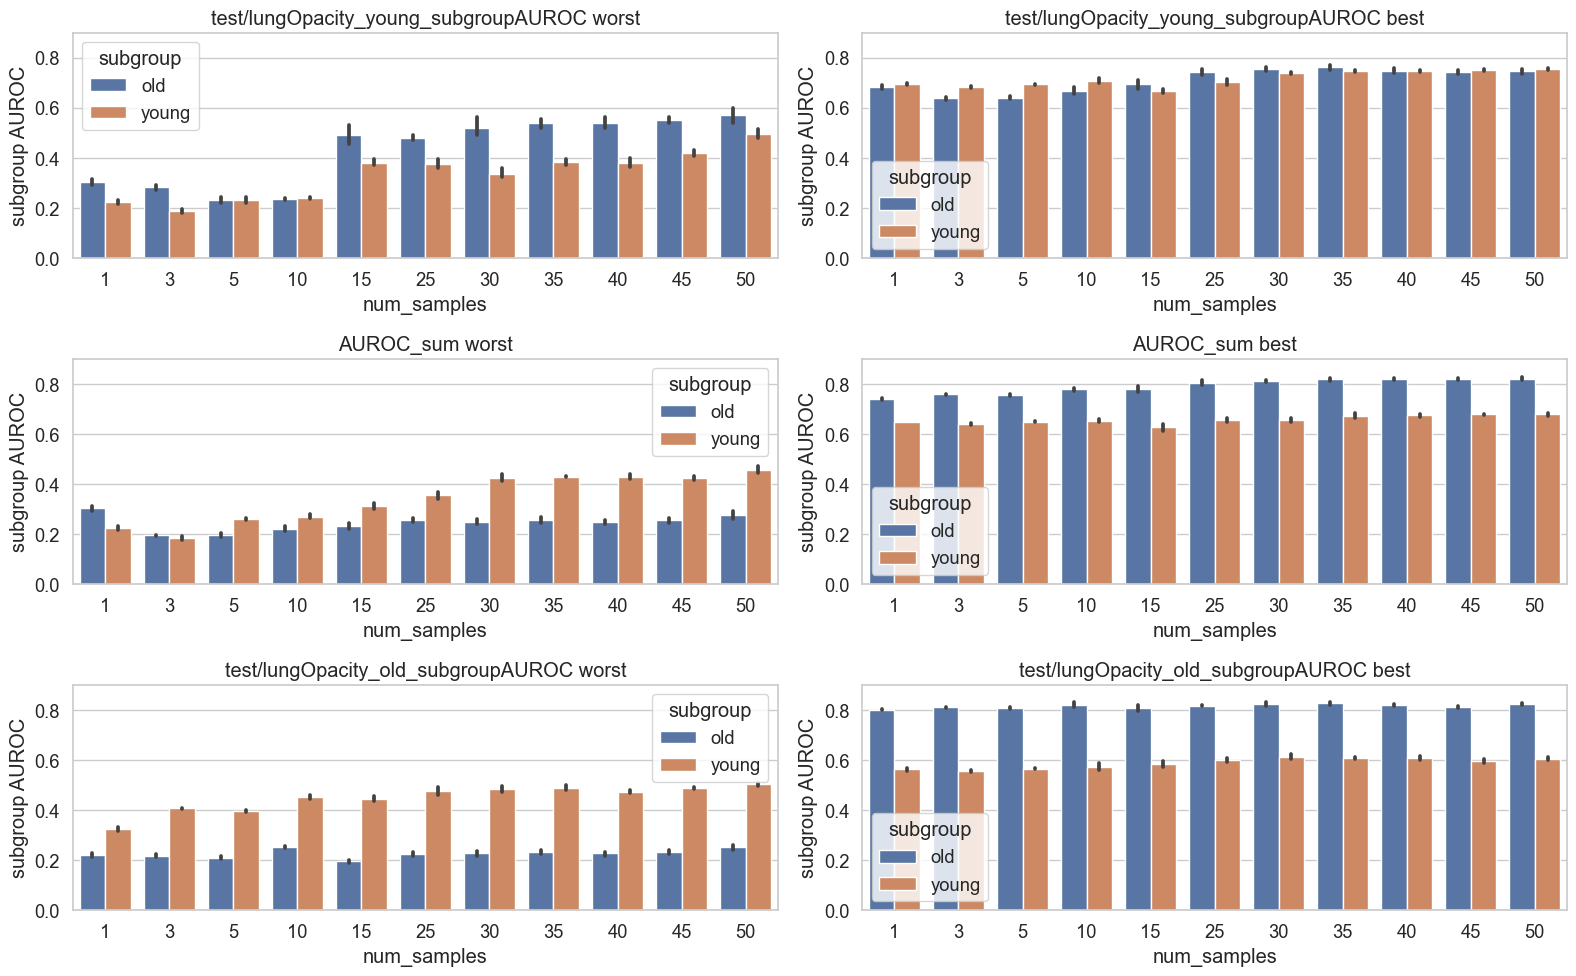

In [197]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
for row, score_var in enumerate(df.score_var.unique()):
    for col, m in enumerate(df["mode"].unique()):
        sns.barplot(
            data = df.loc[(df.score_var == score_var) & (df["mode"] == m)],
            x = "num_samples",
            y = "value",
            hue = "metric",
            ax = axes[row,col],
        )
        axes[row,col].set_title(f"{score_var} {m}")
        axes[row,col].set_ylim([0, 0.9])
        axes[row,col].set_ylabel("subgroup AUROC")
        axes[row,col].legend(title="subgroup", loc="upper left" if m == "min" else "best")
plt.tight_layout()

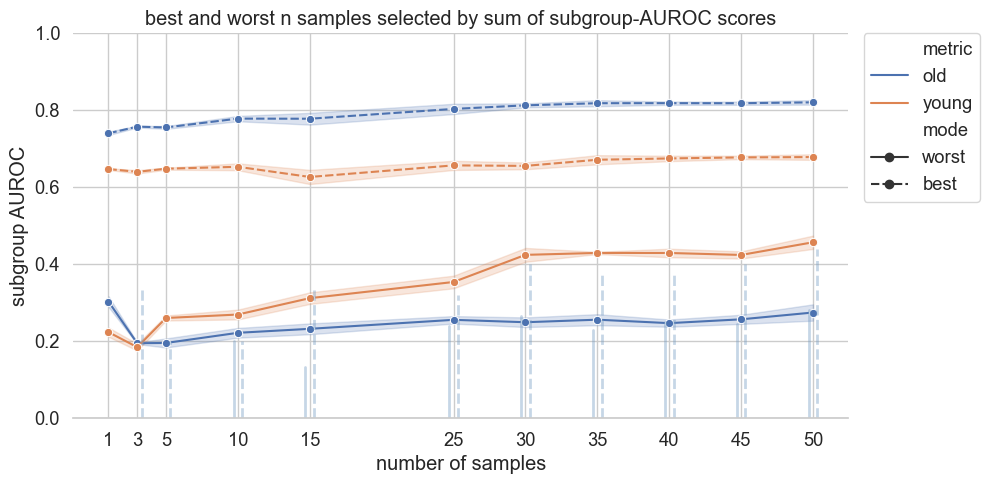

In [198]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data = df.loc[(df.score_var == "AUROC_sum")],
    x = "num_samples",
    y = "value",
    hue = "metric",
    style="mode",
    markers=["o", "o"],
    errorbar="sd",
)
g.set_title("best and worst n samples selected by sum of subgroup-AUROC scores")
g.set_ylim([0, 1])
g.set_ylabel("subgroup AUROC")
g.set_xlabel("number of samples")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
for n_samples in df.num_samples.unique():
    ratio_best = df.loc[(df.score_var == "AUROC_sum") &  (df["mode"] == "best") &  (df["num_samples"] == n_samples)].iloc[0].ratio
    ratio_worst = df.loc[(df.score_var == "AUROC_sum") & (df["mode"] == "worst")&  (df["num_samples"] == n_samples)].iloc[0].ratio
    g.axvline(n_samples-0.3, ymax=ratio_worst, color='#729AC2', linestyle='-', lw=2, alpha=0.4)
    g.axvline(n_samples+0.3, ymax=ratio_best, color='#729AC2', linestyle='--', lw=2, alpha=0.4)
g.set_ylim([0, 1])
plt.xticks(df.num_samples.unique());

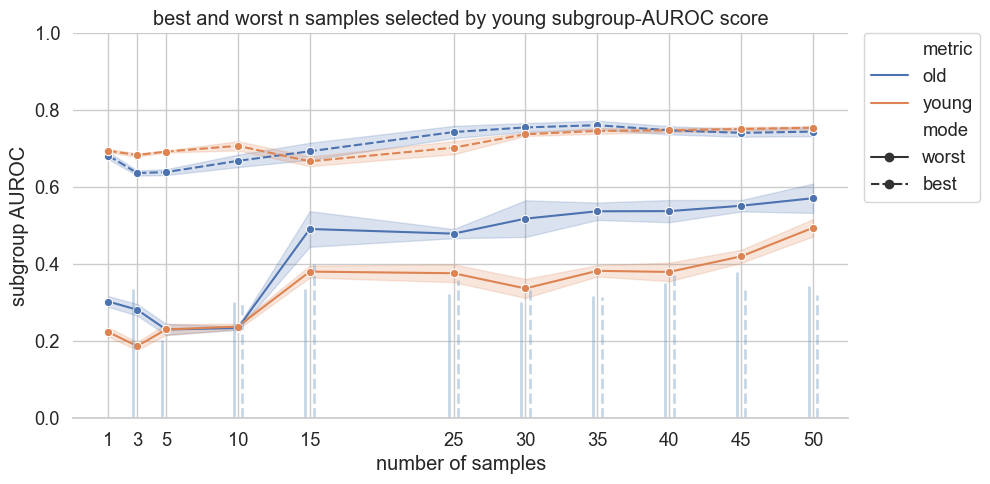

In [199]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data = df.loc[(df.score_var == metric[1])],
    x = "num_samples",
    y = "value",
    hue = "metric",
    style="mode",
    markers=["o", "o"],
    errorbar="sd",
)
g.set_title("best and worst n samples selected by young subgroup-AUROC score")
g.set_ylim([0, 1])
g.set_ylabel("subgroup AUROC")
g.set_xlabel("number of samples")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
for n_samples in df.num_samples.unique():
    ratio_best = df.loc[(df.score_var == metric[1]) &  (df["mode"] == "best") &  (df["num_samples"] == n_samples)].iloc[0].ratio
    ratio_worst = df.loc[(df.score_var == metric[1]) & (df["mode"] == "worst")&  (df["num_samples"] == n_samples)].iloc[0].ratio
    g.axvline(n_samples-0.3, ymax=ratio_worst, color='#729AC2', linestyle='-', lw=2, alpha=0.4)
    g.axvline(n_samples+0.3, ymax=ratio_best, color='#729AC2', linestyle='--', lw=2, alpha=0.4)
g.set_ylim([0, 1])
plt.xticks(df.num_samples.unique());

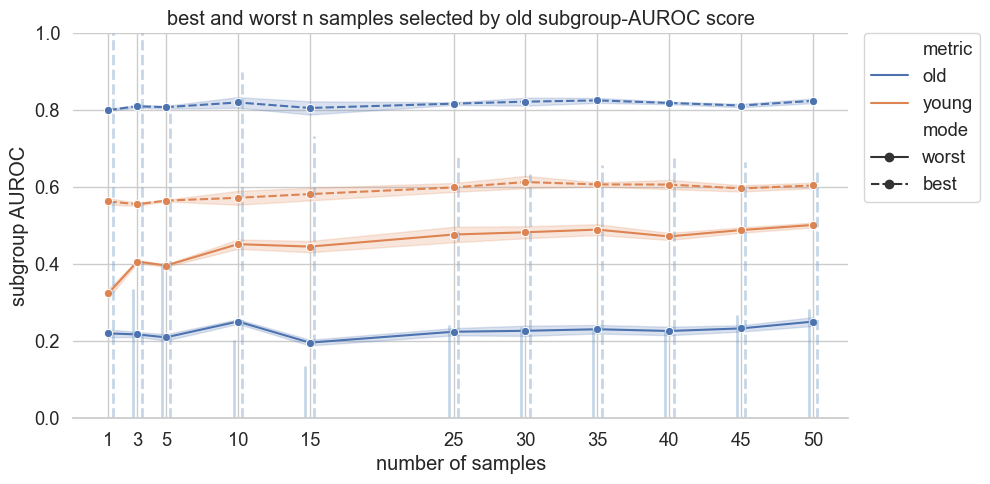

In [200]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data = df.loc[(df.score_var == metric[0])],
    x = "num_samples",
    y = "value",
    hue = "metric",
    style="mode",
    markers=["o", "o"],
    errorbar="sd",
)
g.set_title("best and worst n samples selected by old subgroup-AUROC score")
g.set_ylim([0, 1])
g.set_ylabel("subgroup AUROC")
g.set_xlabel("number of samples")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
for n_samples in df.num_samples.unique():
    ratio_best = df.loc[(df.score_var == metric[0]) &  (df["mode"] == "best") &  (df["num_samples"] == n_samples)].iloc[0].ratio
    ratio_worst = df.loc[(df.score_var == metric[0]) & (df["mode"] == "worst")&  (df["num_samples"] == n_samples)].iloc[0].ratio
    g.axvline(n_samples-0.3, ymax=ratio_worst, color='#729AC2', linestyle='-', lw=2, alpha=0.4)
    g.axvline(n_samples+0.3, ymax=ratio_best, color='#729AC2', linestyle='--', lw=2, alpha=0.4)
g.set_ylim([0, 1])
# show all xticks
plt.xticks(df.num_samples.unique());

# Combined worst and best

In [201]:
with open('../distillation/subsets_combined.json') as f:
    subsets = json.load(f)

In [202]:
df, df_samples = load_csvs_into_df('./2023-10-22 17:03:19-FAE-rsna-age-bs64-dataset-distillation-combined-noDP')
df = df[["test/lungOpacity_old_subgroupAUROC", f"test/lungOpacity_young_subgroupAUROC", "train_loader_num", "seed", "score_var", "mode","num_samples", "ratio"]]

In [203]:
df = df.melt(id_vars=["train_loader_num", "seed", "score_var", "mode","num_samples", "ratio"], var_name="metric", value_name="value")
df.metric = df.metric.str.replace(metric[1],groups[1])
df.metric = df.metric.str.replace(metric[0],groups[0])
df["mode"] = df["mode"].replace("min","worst")
df["mode"] = df["mode"].replace("max","best")

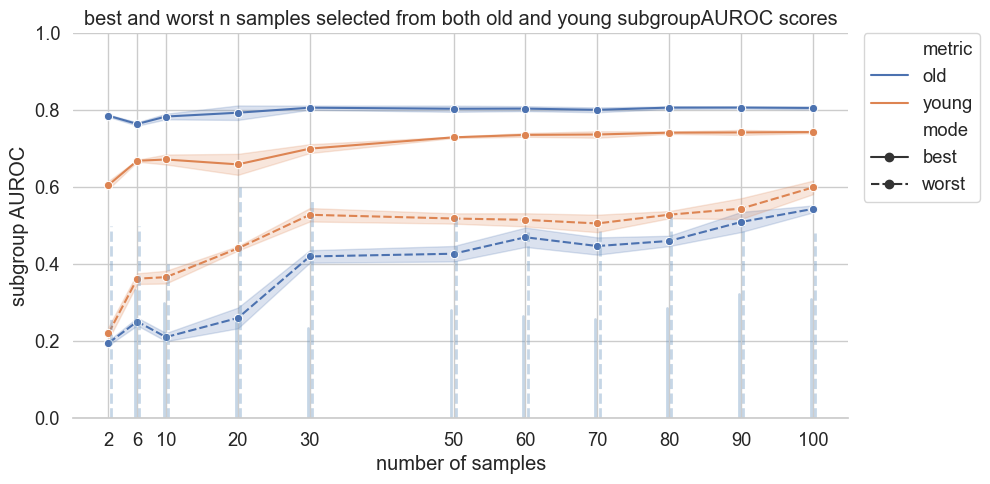

In [204]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data = df,
    x = "num_samples",
    y = "value",
    hue = "metric",
    style="mode",
    markers=["o", "o"],
    errorbar="sd",
)
g.set_title("best and worst n samples selected from both old and young subgroupAUROC scores")
g.set_ylim([0, 1])
g.set_ylabel("subgroup AUROC")
g.set_xlabel("number of samples")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
for n_samples in df.num_samples.unique():
    ratio_best = df.loc[(df["mode"] == "best") &  (df["num_samples"] == n_samples)].iloc[0].ratio
    ratio_worst = df.loc[(df["mode"] == "worst")&  (df["num_samples"] == n_samples)].iloc[0].ratio
    g.axvline(n_samples-0.3, ymax=ratio_worst, color='#729AC2', linestyle='-', lw=2, alpha=0.4)
    g.axvline(n_samples+0.3, ymax=ratio_best, color='#729AC2', linestyle='--', lw=2, alpha=0.4)
g.set_ylim([0, 1])
# show all xticks
plt.xticks(df.num_samples.unique());